In [99]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

# Grid Info

In [100]:
NX = 11
NY = 11
LX = 1
LY = 1
dx = LX / (NX - 1)
dy = LY / (NY - 1)
dt = 0.01
X = np.linspace(0, LX, NX)
Y = np.linspace(0, LY, NY)
#X = np.array([0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]); NX = X.shape[0]
#Y = np.array([0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]); NY = Y.shape[0]
XMG, YMG = np.meshgrid(X, Y, indexing="ij")
X, Y, X.shape, Y.shape, dx, dy

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 (11,),
 (11,),
 0.1,
 0.1)

# Fluid Properties

In [101]:
mu = 0.1
rho = 1.0

lid_velocity = 2.0

# Convert from Field to Vector and Back

In [102]:
def convert_field_to_vector(field):
    """Flattens a field to a vector. Iteration is done row first.

    :param field: shape (i,j)
    :return vector: shape (i*j)
    """
    nx, ny = field.shape
    vector = np.zeros(nx * ny)
    for jdx in range(ny):
        for idx in range(nx):
            ij = jdx * nx + idx
            vector[ij] = field[idx, jdx]
    return vector

def convert_vector_to_field(vector, nx, ny):
    """Stacks a vector into a field. Iteration is done row first.

    :param vector: shape (i*j)
    :return field: shape (i,j)
    """
    field = np.zeros((nx, ny))
    for jdx in range(ny):
        for idx in range(nx):
            ij = jdx * nx + idx
            field[idx, jdx] = vector[ij]
    return field

vec = np.arange(0,20,1)
print(vec, vec.shape)

fld = convert_vector_to_field(vec, 5, 4)
print(fld, fld.shape)

back2vec = convert_field_to_vector(fld)
print(back2vec, back2vec.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] (20,)
[[ 0.  5. 10. 15.]
 [ 1.  6. 11. 16.]
 [ 2.  7. 12. 17.]
 [ 3.  8. 13. 18.]
 [ 4.  9. 14. 19.]] (5, 4)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.] (20,)


# Write input file

Write input file for ```splittor```

In [103]:
with open("grid.txt", "w") as f:
    f.write(f"NX  {NX}  NY  {NY}  NZ  {1}  D  {2}\n")
    f.write("X  Y  Z  BCTYPE  UVAL  VVAL  PVAL\n")
    for jdx in range(NY):
        for idx in range(NX):
            ij = jdx * NX + idx
            BCTYPE = 0
            UVAL = 0
            VVAL = 0
            PVAL = 0
            if jdx == NY - 1:
                BCTYPE = 1
                UVAL = lid_velocity
            elif jdx == 0 or idx == 0 or idx == NX - 1:
                BCTYPE = 1
            f.write(f"{X[idx]:.2f}  {Y[jdx]:.2f}  {BCTYPE:2d}  {UVAL:.2f}  {VVAL:.2f}  {PVAL:.2f}\n")

# Projection Method
---

From the [Wikipedia page on the projection method:](https://en.wikipedia.org/wiki/Projection_method_(fluid_dynamics))

The incompressible Navier-Stokes equation is (in vector form):
\begin{equation} \tag{NSE}
\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla) \mathbf{u} = - \frac{1}{\rho} \nabla p + \nu \nabla^2 \mathbf{u}
\end{equation}

where $\nu = \mu / \rho$: the kinematic viscosity is equal to the dynamic viscosity divided by the density.

The effect of gravity or any body forces can be included on the right hand side, where the units are m/s^2 (acceleration).

The two steps of the projection method are as follows:

## 1) Compute an Intermediate Velocity

\begin{equation} \tag{1}
\frac{\mathbf{u}^* - \mathbf{u}^n}{\Delta t} = - (\mathbf{u}^n \cdot \nabla) \mathbf{u}^n + \nu \nabla^2 \mathbf{u}^n
\end{equation}

Note that this equation presents an explicit step. Implicit and semi-implicit steps are also possible.

## 2) Correct the Intermediate Velocity

\begin{equation} \tag{2}
\mathbf{u}^{n+1} = \mathbf{u}^* - \frac{\Delta t}{\rho} \nabla p^{n+1}
\end{equation}

This step can be rewritten as follows, to make clear that the algorithm is fundamentally an operator splitting approach. The first step only considers viscous forces, while the second step considers the pressure forces. The result from the first step is "projected" back into the space of incompressibilty.
\begin{equation} \nonumber{}
\frac{\mathbf{u}^{n+1} - \mathbf{u}^*}{\Delta t} = - \frac{1}{\rho} \nabla p^{n+1}
\end{equation}

The right hand side of Step 2 requires knowledge of the pressure field. This can be obtained by solving the following Poisson equation:
\begin{equation} \tag{1.5}
\nabla^2 p^{n+1} = \frac{\rho}{\Delta t} \nabla \cdot \mathbf{u}^*
\end{equation}

# Numerical Experiments
---
Consider the lid-driven cavity on the grid described above. A velocity is prescribed of 0.1 m/s to the right at the lid. Let $\Omega$ represent the edge of the domain.

\begin{equation} \notag{}
\begin{split}
v = 0 \space \forall \space v \in \Omega \\
u(x=0) = 0\\
u(y=0) = 0 \\
u(y=LY) = 0.1 \\
u(x=LX) = 0 \\
\end{split}
\end{equation}



## Explicit Step to Intermediate Velocity

\begin{equation} \tag{1.E}
\frac{\mathbf{u}^* - \mathbf{u}^n}{\Delta t} = - (\mathbf{u}^n \cdot \nabla) \mathbf{u}^n + \nu \nabla^2 \mathbf{u}^n
\end{equation}

Expanding into two dimensions:
\begin{split}
u^* = u^n + \Delta t \left( - u\frac{\partial u}{\partial x} - v\frac{\partial u}{\partial y} + \frac{\mu}{\rho} \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) \right) \\
v^* = v^n + \Delta t \left( - u\frac{\partial v}{\partial x} - v\frac{\partial v}{\partial y} + \frac{\mu}{\rho} \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) \right) \\
\end{split}

Discretizing:
\begin{split}

\end{split}

In [104]:
u_n = np.zeros(NX * NY)
v_n = np.zeros(NX * NY)

u_star = np.zeros(NX * NY)
v_star = np.zeros(NX * NY)

# set u b.c. at top of cavity
for jdx in range(NY):
    for idx in range(NX):
        ij = jdx * NX + idx
        if jdx == NY - 1:
            u_n[ij] = lid_velocity

# calculate intermediate velocity
for jdx in range(NY):
    for idx in range(NX):
        ij = jdx * NX + idx
        im1 = jdx * NX + idx - 1
        ip1 = jdx * NX + idx + 1
        jm1 = (jdx - 1) * NX + idx
        jp1 = (jdx + 1) * NX + idx
        # set boundary conditions
        if jdx == NY - 1:
            u_star[ij] = lid_velocity
            v_star[ij] = 0
            continue
        elif jdx == 0 or idx == 0 or idx == NX - 1:
            u_star[ij] = 0
            v_star[ij] = 0
            continue
        # grid steps
        dx_p = X[idx + 1] - X[idx]
        dx_m = X[idx] - X[idx - 1]
        dy_p = Y[jdx + 1] - Y[jdx]
        dy_m = Y[jdx] - Y[jdx - 1]
        # first order derivatives
        dudx_p = (u_n[ip1] - u_n[ij]) / dx_p
        dudx_m = (u_n[ij] - u_n[im1]) / dx_m
        dudy_p = (u_n[jp1] - u_n[ij]) / dy_p
        dudy_m = (u_n[ij] - u_n[jm1]) / dy_m
        dvdx_p = (v_n[ip1] - v_n[ij]) / dx_p
        dvdx_m = (v_n[ij] - v_n[im1]) / dx_m
        dvdy_p = (v_n[jp1] - v_n[ij]) / dy_p
        dvdy_m = (v_n[ij] - v_n[jm1]) / dy_m
        # first order terms
        ududx = u_n[ij] * 0.5 * (dudx_p + dudx_m)
        vdudy = v_n[ij] * 0.5 * (dudy_p + dudy_m)
        udvdx = u_n[ij] * 0.5 * (dvdx_p + dvdx_m)
        vdvdy = v_n[ij] * 0.5 * (dvdy_p + dvdy_m)
        # second order terms
        d2udx2 = (dudx_p - dudx_m) / (0.5 * (dx_p + dx_m))
        d2udy2 = (dudy_p - dudy_m) / (0.5 * (dy_p + dy_m))
        d2vdx2 = (dvdx_p - dvdx_m) / (0.5 * (dx_p + dx_m))
        d2vdy2 = (dvdy_p - dvdy_m) / (0.5 * (dy_p + dy_m))
        # store intermediate velocities
        u_star[ij] = u_n[ij] + dt * (-ududx - vdudy + (mu/rho) * (d2udx2 + d2udy2))
        v_star[ij] = v_n[ij] + dt * (-udvdx - vdvdy + (mu/rho) * (d2vdx2 + d2vdy2))

In [105]:
"""20251105@11:51PM
The output of the above cell is confirmed to match the chorin projection tentative velocity from the notebook in the 2d heat conduction repo.
Basically, this is correct.
You should see that:
    the lid has a u_star of 2.0, and the inner points immediately below it have a u_star of 0.2
    v_star should be still all zero
Note that we use ij indexing (not xy) which is why the field is sideways
"""
convert_vector_to_field(u_star, NX, NY)

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 2. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 2. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 2. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 2. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 2. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 2. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 2. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 2. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 2. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 2. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 2. ]])

## Partially Implicit Step to Intermediate Velocity

A semi-implicit step may offer improved (solution) stability, due to the implicit nature, while avoiding the nonlinear solve needed if the self-advection term is also made implicit.

\begin{equation} \notag{}
\frac{\mathbf{u}^* - \mathbf{u}^n}{\Delta t} = - (\mathbf{u}^n \cdot \nabla) \mathbf{u}^n + \nu \nabla^2 \mathbf{u}^*
\end{equation}

Rearranging:
\begin{equation} \notag{}
\frac{\mathbf{u}^*}{\Delta t} - \nu \nabla^2 \mathbf{u}^*= - (\mathbf{u}^n \cdot \nabla) \mathbf{u}^n + \frac{\mathbf{u}^n}{\Delta t}
\end{equation}

Expanding into two dimensions:
\begin{split}
\frac{u^*}{\Delta t} - \frac{\mu}{\rho} \left( \frac{\partial^2 u^*}{\partial x^2} + \frac{\partial^2 u^*}{\partial y^2} \right) = \frac{u}{\Delta t} - u\frac{\partial u}{\partial x} - v\frac{\partial u}{\partial y}\\
\frac{v^*}{\Delta t} - \frac{\mu}{\rho} \left( \frac{\partial^2 v^*}{\partial x^2} + \frac{\partial^2 v^*}{\partial y^2} \right) = \frac{v}{\Delta t} - u\frac{\partial v}{\partial x} - v\frac{\partial v}{\partial y}\\
\end{split}

Discretizing:

### Deiscretization of Second Order Term
Note that the discretization of the second order derivative on an unequal grid is as follows:
\begin{equation} \nonumber{}
\frac{\partial^2 \phi}{\partial x^2} \approx \frac{\frac{\partial\phi}{\partial x}|_+ - \frac{\partial\phi}{\partial x}|_- }{\frac{1}{2} (\Delta_+ + \Delta_-)} = \frac{ \frac{\phi_+ - \phi}{\Delta_+} - \frac{\phi - \phi_-}{\Delta_-} }{ \frac{1}{2} (\Delta_+ + \Delta_-) }
\end{equation}

Multiply the above by $\frac{\Delta_+ \Delta_-}{\Delta_+ \Delta_-}$
\begin{equation} \nonumber{}
\frac{\partial^2 \phi}{\partial x^2} \approx 2 \left( \frac{\Delta_-(\phi_+ - \phi) - \Delta_+(\phi - \phi_-)}{\Delta_+ \Delta_- (\Delta_+ + \Delta_-)} \right)
\end{equation}

The terms can be grouped as follows:
\begin{equation} \nonumber{}
\frac{\partial^2 \phi}{\partial x^2} \approx \frac{2 \Delta_-}{\Delta_+ \Delta_- (\Delta_+ + \Delta_-)} \phi_+ + \frac{2(-\Delta_--\Delta_+)}{\Delta_+ \Delta_- (\Delta_+ + \Delta_-)} \phi + \frac{2 \Delta_+}{\Delta_+ \Delta_- (\Delta_+ + \Delta_-)} \phi_-
\end{equation}

Cancel terms to get:

\begin{equation} \nonumber{}
\frac{\partial^2 \phi}{\partial x^2}
\approx 
\frac{2}{\Delta_+ (\Delta_+ + \Delta_-)} \phi_+
+ \frac{-2}{\Delta_+ \Delta_-} \phi
+ \frac{2}{\Delta_- (\Delta_+ + \Delta_-)} \phi_-
\end{equation}

In practice, to avoid errors and such due to numerical precision, the diagonal term can be written in terms of the two of diagonal terms.
\begin{equation} \nonumber{}
\begin{split}
c_+ &= \frac{2}{\Delta_+ (\Delta_+ + \Delta_-)}\\
c_- &= \frac{2}{\Delta_- (\Delta_+ + \Delta_-)}\\
c_0 &= - (c_+ + c_-)
\end{split}
\end{equation}

In [106]:
u_n = np.zeros(NX * NY)
v_n = np.zeros(NX * NY)

# set u b.c. at top of cavity
for jdx in range(NY):
    for idx in range(NX):
        ij = jdx * NX + idx
        if jdx == NY - 1:
            u_n[ij] = lid_velocity

# create system to calculate intermediate velocity
Au = np.zeros((NX * NY, NX * NY))
bu = np.zeros(NX * NY)
Av = np.zeros((NX * NY, NX * NY))
bv = np.zeros(NX * NY)

for jdx in range(NY):
    for idx in range(NX):
        ij = jdx * NX + idx
        im1 = jdx * NX + idx - 1
        ip1 = jdx * NX + idx + 1
        jm1 = (jdx - 1) * NX + idx
        jp1 = (jdx + 1) * NX + idx
        # Boundary conditions
        if jdx == NY-1:
            Au[ij, ij] = 1.0
            Av[ij, ij] = 1.0
            bu[ij] = lid_velocity
            bv[ij] = 0.0
            continue
        if jdx == 0 or idx == 0 or idx == NX-1:
            Au[ij, ij] = 1.0
            Av[ij, ij] = 1.0
            bu[ij] = 0.0
            bv[ij] = 0.0
            continue

        # Grid spacing
        dx_p = X[idx + 1] - X[idx]
        dx_m = X[idx] - X[idx - 1]
        dy_p = Y[jdx + 1] - Y[jdx]
        dy_m = Y[jdx] - Y[jdx - 1]

        # Coefficients for nonuniform Laplacian
        cx_p = 2.0 / (dx_p * (dx_p + dx_m))
        cx_m = 2.0 / (dx_m * (dx_p + dx_m))
        cx_0 = -(cx_p + cx_m)

        cy_p = 2.0 / (dy_p * (dy_p + dy_m))
        cy_m = 2.0 / (dy_m * (dy_p + dy_m))
        cy_0 = -(cy_p + cy_m)

        # first order derivatives
        dudx_p = (u_n[ip1] - u_n[ij]) / dx_p
        dudx_m = (u_n[ij] - u_n[im1]) / dx_m
        dudy_p = (u_n[jp1] - u_n[ij]) / dy_p
        dudy_m = (u_n[ij] - u_n[jm1]) / dy_m
        dvdx_p = (v_n[ip1] - v_n[ij]) / dx_p
        dvdx_m = (v_n[ij] - v_n[im1]) / dx_m
        dvdy_p = (v_n[jp1] - v_n[ij]) / dy_p
        dvdy_m = (v_n[ij] - v_n[jm1]) / dy_m
        # first order terms
        ududx = u_n[ij] * 0.5 * (dudx_p + dudx_m)
        vdudy = v_n[ij] * 0.5 * (dudy_p + dudy_m)
        udvdx = u_n[ij] * 0.5 * (dvdx_p + dvdx_m)
        vdvdy = v_n[ij] * 0.5 * (dvdy_p + dvdy_m)

        # Assemble Helmholtz operator Au
        Au[ij, ij] = 1 / dt - (mu / rho) * (cx_0 + cy_0)
        Au[ij, ip1] = -(mu / rho) * cx_p
        Au[ij, im1] = -(mu / rho) * cx_m
        Au[ij, jp1] = -(mu / rho) * cy_p
        Au[ij, jm1] = -(mu / rho) * cy_m

        # Assemble RHS
        bu[ij] = u_n[ij] / dt - ududx - vdudy

        # Assemble Helmholtz operator Av
        Av[ij, ij] = 1 / dt - (mu / rho) * (cx_0 + cy_0)
        Av[ij, ip1] = -(mu / rho) * cx_p
        Av[ij, im1] = -(mu / rho) * cx_m
        Av[ij, jp1] = -(mu / rho) * cy_p
        Av[ij, jm1] = -(mu / rho) * cy_m

        # RHS
        bv[ij] = v_n[ij] / dt - udvdx - vdvdy

# Solve
u_star = np.linalg.solve(Au, bu)
v_star = np.linalg.solve(Av, bv)

In [107]:
for row in convert_vector_to_field(u_star, NX, NY).round(2):
    print(row)
for row in convert_vector_to_field(v_star, NX, NY).round(2):
    print(row)

[ 0.  0. -0.  0.  0. -0. -0. -0. -0. -0.  2.]
[-0.    0.    0.    0.    0.    0.    0.    0.    0.01  0.16  2.  ]
[-0.    0.    0.    0.    0.    0.    0.    0.    0.01  0.17  2.  ]
[-0.    0.    0.    0.    0.    0.    0.    0.    0.01  0.17  2.  ]
[-0.    0.    0.    0.    0.    0.    0.    0.    0.01  0.17  2.  ]
[0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.17 2.  ]
[0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.17 2.  ]
[0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.17 2.  ]
[0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.17 2.  ]
[-0.    0.    0.    0.    0.    0.    0.    0.    0.01  0.16  2.  ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
[ 0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0.]
[-0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.  0.  0.  0.  0.  0.  0. 

## Pressure Poisson Equation

\begin{equation} \tag{1.5}
\nabla^2 p^{n+1} = \frac{\rho}{\Delta t} \nabla \cdot \mathbf{u}^*
\end{equation}

Expanding:
\begin{equation} \nonumber{}
\frac{\partial^2 p^{n+1}}{\partial x^2} + \frac{\partial^2 p^{n+1}}{\partial y^2} = \frac{\rho}{\Delta t} \left( \frac{\partial u^*}{\partial x} + \frac{\partial v^*}{\partial y} \right)
\end{equation}

Discretizing:
\begin{equation} \nonumber{}

\end{equation}


In [108]:
p_np1 = np.zeros(NX * NY)
A = np.zeros((NX * NY, NX * NY))
b = np.zeros(NX * NY)

# build linear system
for jdx in range(NY):
    for idx in range(NX):
        ij = jdx * NX + idx
        im1 = jdx * NX + idx - 1
        ip1 = jdx * NX + idx + 1
        jm1 = (jdx - 1) * NX + idx
        jp1 = (jdx + 1) * NX + idx
        # handle boundaries
        if jdx == NY - 1:
            A[ij, ij] = 1
            # A[ij, im1] = -1  # pressure needs to be fixed at a reference value somewhere.
            b[ij] = 0
            continue
        elif jdx == 0:
            A[ij, ij] = 1
            A[ij, jp1] = -1
            b[ij] = 0
            continue
        elif idx == 0:
            A[ij, ij] = 1
            A[ij, ip1] = -1
            b[ij] = 0
            continue
        elif idx == NX - 1:
            A[ij, ij] = 1
            A[ij, im1] = -1
            b[ij] = 0
            continue
        # grid steps
        dx_p = X[idx + 1] - X[idx]
        dx_m = X[idx] - X[idx - 1]
        dy_p = Y[jdx + 1] - Y[jdx]
        dy_m = Y[jdx] - Y[jdx - 1]
        #
        dudx_p = (u_star[ip1] - u_star[ij]) / dx_p
        dudx_m = (u_star[ij] - u_star[im1]) / dx_m
        # dudy_p = (u_star[jp1] - u_star[ij]) / dy_p
        # dudy_m = (u_star[ij] - u_star[jm1]) / dy_m
        # dvdx_p = (v_star[ip1] - v_star[ij]) / dx_p
        # dvdx_m = (v_star[ij] - v_star[im1]) / dx_m
        dvdy_p = (v_star[jp1] - v_star[ij]) / dy_p
        dvdy_m = (v_star[ij] - v_star[jm1]) / dy_m
        #
        A[ij, ij] = -2 * (dx_p + dx_m) / (dx_p * dx_m * (dx_p + dx_m)) - 2 * (dy_p + dy_m) / (dy_p * dy_m * (dy_p + dy_m))
        A[ij, ip1] = 2 * dx_m / (dx_p * dx_m * (dx_p + dx_m))
        A[ij, im1] = 2 * dx_p / (dx_p * dx_m * (dx_p + dx_m))
        A[ij, jp1] = 2 * dy_m / (dy_p * dy_m * (dy_p + dy_m))
        A[ij, jm1] = 2 * dy_p / (dy_p * dy_m * (dy_p + dy_m))
        #
        b[ij] = rho / dt * (0.5 * (dudx_p + dudx_m) + 0.5 * (dvdy_p + dvdy_m))

print(np.linalg.norm(A - A.T))

# solve (via closed form OLS here since the system is small)
#p_np1 = np.linalg.inv(A.T @ A) @ A.T @ b  # TODO: np.linalg.solve lol not OLS
p_np1 = np.linalg.solve(A, b)

854.9023336030849


In [109]:
for line in reversed(convert_vector_to_field(p_np1, NX, NY).T):
    for number in line:
        print(f"{number:7.3f}", end=" ")
    print()
# plt.imshow(convert_vector_to_field(p_np1, NX, NY).T, origin="lower")

  0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000 
 -0.441  -0.441  -0.192  -0.082  -0.031   0.000   0.031   0.082   0.192   0.441   0.441 
 -0.295  -0.295  -0.185  -0.100  -0.043   0.000   0.043   0.100   0.185   0.295   0.295 
 -0.190  -0.190  -0.142  -0.089  -0.042   0.000   0.042   0.089   0.142   0.190   0.190 
 -0.128  -0.128  -0.104  -0.070  -0.035   0.000   0.035   0.070   0.104   0.128   0.128 
 -0.090  -0.090  -0.076  -0.054  -0.027   0.000   0.027   0.054   0.076   0.090   0.090 
 -0.065  -0.065  -0.056  -0.041  -0.021   0.000   0.021   0.041   0.056   0.065   0.065 
 -0.049  -0.049  -0.043  -0.032  -0.017   0.000   0.017   0.032   0.043   0.049   0.049 
 -0.040  -0.040  -0.035  -0.026  -0.014   0.000   0.014   0.026   0.035   0.040   0.040 
 -0.036  -0.036  -0.031  -0.023  -0.012   0.000   0.012   0.023   0.031   0.036   0.036 
 -0.036  -0.036  -0.031  -0.023  -0.012   0.000   0.012   0.023   0.031   0.036   0.036 


## Projection

\begin{equation} \tag{2}
\mathbf{u}^{n+1} = \mathbf{u}^* - \frac{\Delta t}{\rho} \nabla p^{n+1}
\end{equation}

Expanding:

\begin{split}
u^{n+1} = u^* - \frac{\Delta t}{\rho} \frac{\partial p}{\partial x}\\
v^{n+1} = v^* - \frac{\Delta t}{\rho} \frac{\partial p}{\partial y}\\
\end{split}

In [110]:
u_np1 = np.zeros(NX * NY)
v_np1 = np.zeros(NX * NY)

for jdx in range(NY):
    for idx in range(NX):
        ij = jdx * NX + idx
        im1 = jdx * NX + idx - 1
        ip1 = jdx * NX + idx + 1
        jm1 = (jdx - 1) * NX + idx
        jp1 = (jdx + 1) * NX + idx
        # handle boundaries
        if jdx == NY - 1:
            u_np1[ij] = lid_velocity
            v_np1[ij] = 0
            continue
        elif jdx == 0 or idx == 0 or idx == NX - 1:
            u_np1[ij] = 0
            v_np1[ij] = 0
            continue
        # grid steps
        dx_p = X[idx + 1] - X[idx]
        dx_m = X[idx] - X[idx - 1]
        dy_p = Y[jdx + 1] - Y[jdx]
        dy_m = Y[jdx] - Y[jdx - 1]
        #
        dpdx_p = (p_np1[ip1] - p_np1[ij]) / dx_p
        dpdx_m = (p_np1[ij] - p_np1[im1]) / dx_m
        dpdy_p = (p_np1[jp1] - p_np1[ij]) / dy_p
        dpdy_m = (p_np1[ij] - p_np1[jm1]) / dy_m
        #
        u_np1[ij] = u_star[ij] - (dt / rho) * (0.5 * (dpdx_p + dpdx_m))
        v_np1[ij] = v_star[ij] - (dt / rho) * (0.5 * (dpdy_p + dpdy_m))

In [111]:
for line in reversed(convert_vector_to_field(u_np1, NX, NY).T):
    for number in line:
        print(f"{number:7.3f}", end=" ")
    print()

  2.000   2.000   2.000   2.000   2.000   2.000   2.000   2.000   2.000   2.000   2.000 
  0.000   0.143   0.149   0.160   0.164   0.165   0.164   0.160   0.149   0.143   0.000 
  0.000   0.007   0.004   0.007   0.009   0.010   0.009   0.007   0.004   0.007   0.000 
  0.000  -0.001  -0.004  -0.004  -0.003  -0.003  -0.003  -0.004  -0.004  -0.001   0.000 
  0.000  -0.001  -0.003  -0.003  -0.003  -0.003  -0.003  -0.003  -0.003  -0.001   0.000 
  0.000  -0.001  -0.002  -0.002  -0.003  -0.003  -0.003  -0.002  -0.002  -0.001   0.000 
  0.000  -0.000  -0.001  -0.002  -0.002  -0.002  -0.002  -0.002  -0.001  -0.000   0.000 
  0.000  -0.000  -0.001  -0.001  -0.002  -0.002  -0.002  -0.001  -0.001  -0.000   0.000 
  0.000  -0.000  -0.001  -0.001  -0.001  -0.001  -0.001  -0.001  -0.001  -0.000   0.000 
  0.000  -0.000  -0.001  -0.001  -0.001  -0.001  -0.001  -0.001  -0.001  -0.000   0.000 
  0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000 


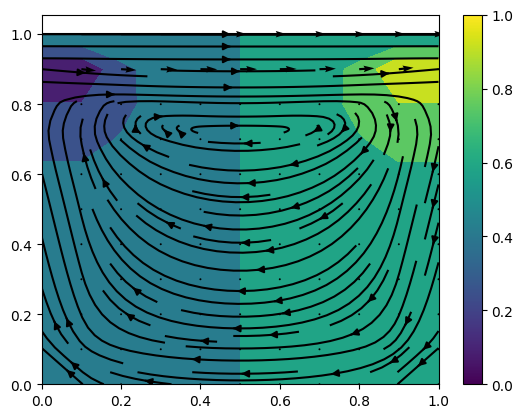

In [112]:
#plt.figure(figsize=(5,4))
plt.contourf(XMG, YMG, convert_vector_to_field(p_np1, NX, NY))
plt.quiver(XMG.T, YMG.T, convert_vector_to_field(u_np1, NX, NY).T, convert_vector_to_field(v_np1, NX, NY).T, color="black")
plt.streamplot(XMG.T, YMG.T, convert_vector_to_field(u_np1, NX, NY).T, convert_vector_to_field(v_np1, NX, NY).T, color="black")
plt.colorbar()

## Implicit Step to Intermediate Velocity

\begin{equation} \notag{}
\frac{\mathbf{u}^* - \mathbf{u}^n}{\Delta t} = - (\mathbf{u}^* \cdot \nabla) \mathbf{u}^* + \nu \nabla^2 \mathbf{u}^*
\end{equation}

In [113]:
NZ = 1
for kdx in range(NZ):
    for jdx in range(NY):
        for idx in range(NX):
            ijk = kdx * (NX * NY) + jdx * NX + idx

            im1 = kdx * (NX * NY) + jdx * NX + (idx - 1)
            ip1 = kdx * (NX * NY) + jdx * NX + (idx + 1)

            jm1 = kdx * (NX * NY) + (jdx - 1) * NX + idx
            jp1 = kdx * (NX * NY) + (jdx + 1) * NX + idx

            km1 = (kdx - 1) * (NX * NY) + jdx * NX + idx
            kp1 = (kdx + 1) * (NX * NY) + jdx * NX + idx